In [1]:
import torch
import random
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..', 'Model', 'PyTorch_CIFAR10'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from cifar10_models.resnet import resnet18

In [26]:
# weight distribution for all layers

import torch
import matplotlib.pyplot as plt

def analyze_model_weights(model, folder_name):
    weights = []
    
    for param in model.parameters():
        if param.requires_grad:  # 학습 가능한 가중치만 선택
            weights.append(param.data.view(-1))  # 1D 텐서로 변환
    
    weights = torch.cat(weights)  # 모든 가중치를 하나의 벡터로 결합
    
    abs_min = torch.min(torch.abs(weights)).item()
    abs_max = torch.max(torch.abs(weights)).item()
    
    # 0보다 큰 값 중 최소값 찾기
    positive_weights = weights[weights > 0]  # 0보다 큰 값 필터링
    min_positive = positive_weights.min().item() if positive_weights.numel() > 0 else None  # 값이 있을 때만 최소값 계산
    
    # 0보다 작은 값 중 최소값 찾기
    negative_weights = weights[weights < 0]  
    min_negative = negative_weights.max().item() if negative_weights.numel() > 0 else None  # 값이 있을 때만 최소값 계산


    print(f"Absolute Min: {abs_min}, Absolute Max: {abs_max:.5f}")
    print(f"Min Positive Value: {min_positive}, Min Negative Value: {min_negative}")
    
    # 가중치 분포 시각화
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1행 2열 서브플롯
    
    # 전체 제목 (중앙)
    fig.suptitle(folder_name, fontsize=16, fontweight='bold')  

    # Linear scale subplot
    axes[0].hist(weights.cpu().numpy(), bins=200, alpha=0.75, color='blue')
    axes[0].set_xlabel("Weight Values")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Weight Distribution (Linear Scale)")
    axes[0].grid(True)

    # Log scale subplot
    axes[1].hist(weights.cpu().numpy(), bins=200, alpha=0.75, color='blue')
    axes[1].set_xlabel("Weight Values")
    axes[1].set_ylabel("Frequency (log scale)")
    axes[1].set_title("Weight Distribution (Log Scale)")
    axes[1].set_yscale('log')  # 로그 스케일 적용
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    return abs_min, abs_max

Absolute Min: 0.0, Absolute Max: 0.24882
Min Positive Value: 2.8966287572984584e-06, Min Negative Value: -2.0657858840422705e-05


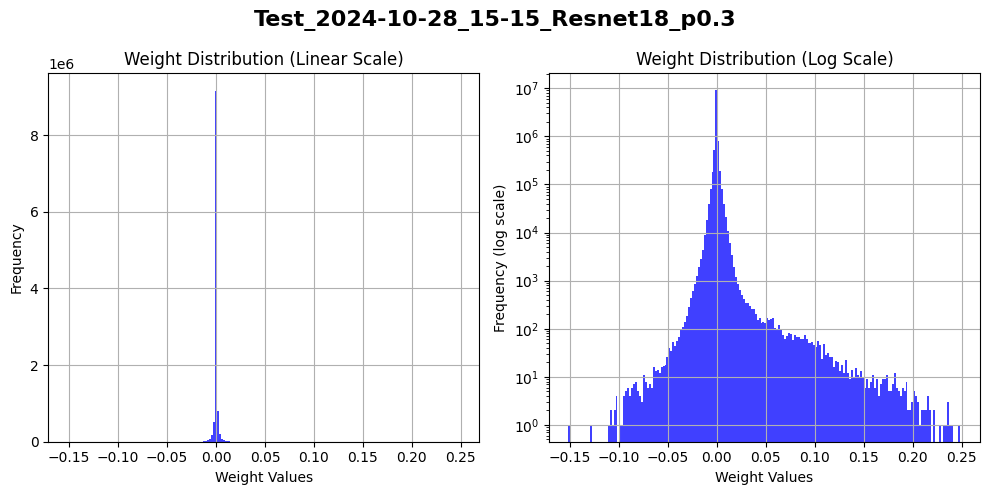

(0.0, 0.2488204836845398)

In [27]:
import torch
import matplotlib.pyplot as plt
import sys
import os

folder_name = 'Test_2024-10-28_15-15_Resnet18_p0.3'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
analyze_model_weights(model, folder_name)

Absolute Min: 0.0, Absolute Max: 0.24882
Min Positive Value: 2.8966287572984584e-06, Min Negative Value: -2.0657858840422705e-05


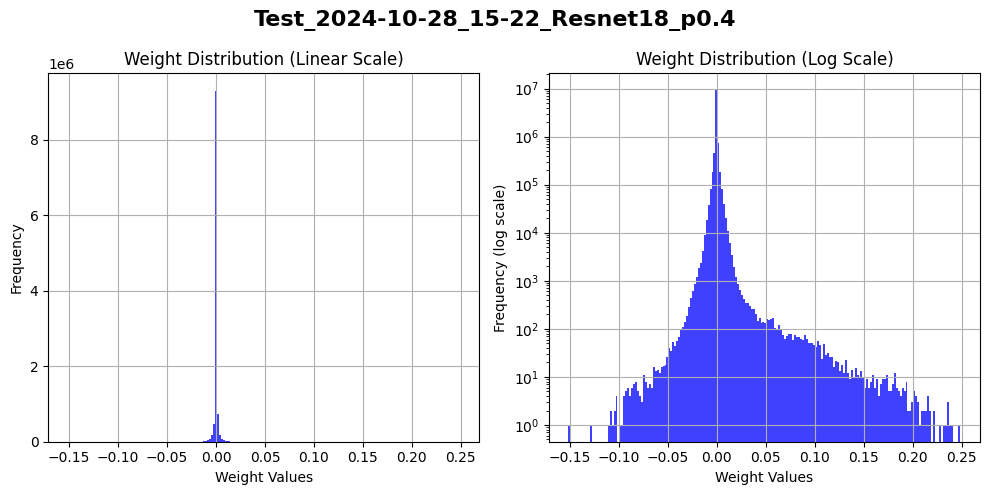

(0.0, 0.2488204836845398)

In [28]:
folder_name = 'Test_2024-10-28_15-22_Resnet18_p0.4'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
analyze_model_weights(model, folder_name)

Absolute Min: 0.0, Absolute Max: 0.24882
Min Positive Value: 2.8966287572984584e-06, Min Negative Value: -2.0657858840422705e-05


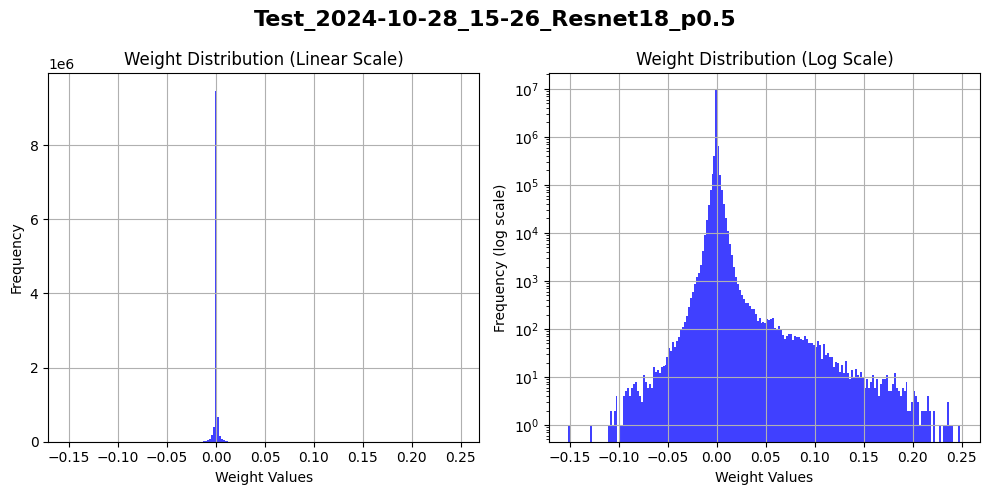

(0.0, 0.2488204836845398)

In [29]:
folder_name = 'Test_2024-10-28_15-26_Resnet18_p0.5'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
analyze_model_weights(model, folder_name)

Absolute Min: 0.0, Absolute Max: 0.24882
Min Positive Value: 2.8966287572984584e-06, Min Negative Value: -2.0657858840422705e-05


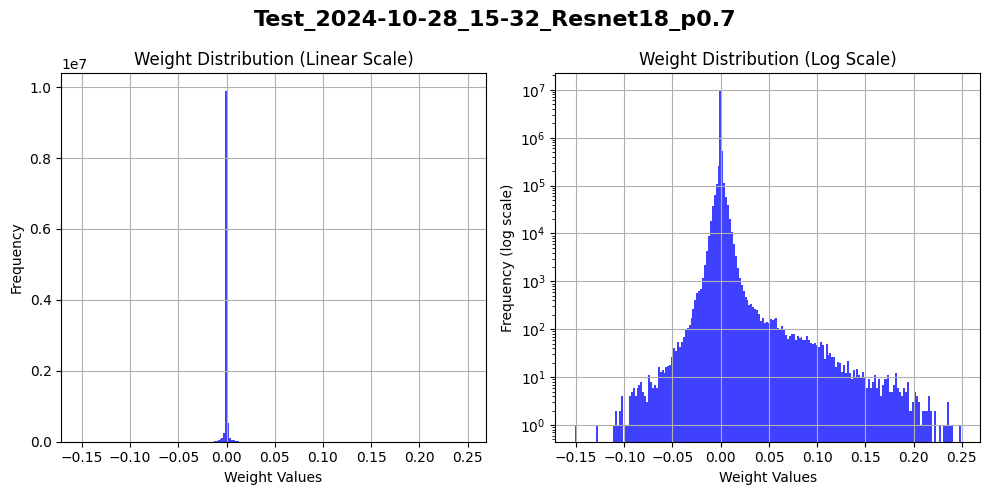

(0.0, 0.2488204836845398)

In [30]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
 
model = torch.load(f'{folder_path}/{model_name}')
analyze_model_weights(model, folder_name)